# Comparison of MLP and Bayes NN on Spam Base dataset

### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import zhusuan as zs


from ucimlrepo import fetch_ucirepo 
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

tf.set_random_seed(123)
np.random.seed(321)

/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/glegeza/Programming/semestr2/bayesian_deep_learning/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

### Load data

In [2]:
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 
  
# metadata 
# print(spambase.metadata) 
  
# variable information 
# print(spambase.variables) 

In [3]:
X, y = X.values, y.values.reshape(-1)
train_X, test_X, train_y_, test_y_ = train_test_split(X, y, test_size=.2, random_state=42)

n_train, x_dim = train_X.shape
n_test = test_X.shape[0]
y_dim = 2

train_y = tf.keras.utils.to_categorical(train_y_, y_dim)
test_y = tf.keras.utils.to_categorical(test_y_, y_dim)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((3680, 57), (3680, 2), (921, 57), (921, 2))

## Standarize data

In [4]:
def standardize(data_train, data_test):
    """
    Standardize a dataset to have zero mean and unit standard deviation.

    :param data_train: 2-D Numpy array. Training data.
    :param data_test: 2-D Numpy array. Test data.

    :return: (train_set, test_set, mean, std), The standardized dataset and
        their mean and standard deviation before processing.
    """
    std = np.std(data_train, 0, keepdims=True)
    std[std == 0] = 1
    mean = np.mean(data_train, 0, keepdims=True)
    data_train_standardized = (data_train - mean) / std
    data_test_standardized = (data_test - mean) / std
    mean, std = np.squeeze(mean, 0), np.squeeze(std, 0)
    return data_train_standardized, data_test_standardized, mean, std

In [5]:
train_X_standard, test_X_standard, _, _ = standardize(train_X, test_X)

### Defintion of parameters

In [6]:
n_hiddens = [64, 32, 16]
layer_sizes = [x_dim] + n_hiddens + [y_dim]

epochs = 50
lr = 0.005
batch_size = 100 

### MLP model

In [7]:
mlp = Sequential()
mlp.add(Dense(layer_sizes[1], activation="relu", input_shape=(x_dim,)))
for out_dim in layer_sizes[2:-1]:
    mlp.add(Dense(out_dim, activation="relu"))
mlp.add(Dense(y_dim, activation="softmax"))

optimizer = Adam(lr=lr)
mlp.compile(
    loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
mlp.build()
mlp.summary()

Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3712      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 6,354
Trainable params: 6,354
Non-trainable params: 0
_________________________________________________________________


In [8]:
training_results = mlp.fit(
                            x=train_X_standard,
                            y=train_y,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(test_X_standard, test_y),
                        )

Train on 3680 samples, validate on 921 samples
Instructions for updating:
Use tf.cast instead.


2024-01-03 21:59:13.536160: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-01-03 21:59:13.558183: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1800000000 Hz
2024-01-03 21:59:13.558673: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55a5e7192200 executing computations on platform Host. Devices:
2024-01-03 21:59:13.558705: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>


Epoch 1/50
3680/3680 [==============================] - 0s 120us/sample - loss: 0.3433 - acc: 0.8666 - val_loss: 0.2049 - val_acc: 0.9338
Epoch 2/50
3680/3680 [==============================] - 0s 26us/sample - loss: 0.1821 - acc: 0.9364 - val_loss: 0.1719 - val_acc: 0.9370
Epoch 3/50
3680/3680 [==============================] - 0s 25us/sample - loss: 0.1511 - acc: 0.9443 - val_loss: 0.1564 - val_acc: 0.9479
Epoch 4/50
3680/3680 [==============================] - 0s 26us/sample - loss: 0.1352 - acc: 0.9476 - val_loss: 0.1725 - val_acc: 0.9414
Epoch 5/50
3680/3680 [==============================] - 0s 27us/sample - loss: 0.1280 - acc: 0.9505 - val_loss: 0.1767 - val_acc: 0.9425
Epoch 6/50
3680/3680 [==============================] - 0s 25us/sample - loss: 0.1127 - acc: 0.9628 - val_loss: 0.1714 - val_acc: 0.9490
Epoch 7/50
3680/3680 [==============================] - 0s 27us/sample - loss: 0.1044 - acc: 0.9641 - val_loss: 0.1735 - val_acc: 0.9403
Epoch 8/50
3680/3680 [==================

In [9]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.xlim([0, 20])
    # plt.ylim(ylim)
    # Tailor x-axis tick marks
    # ax.xaxis.set_major_locator(MultipleLocator(5))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

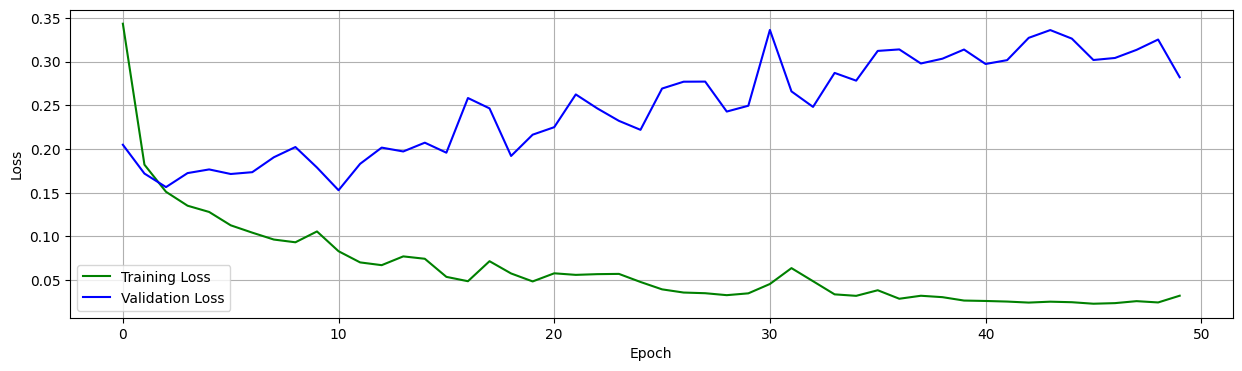

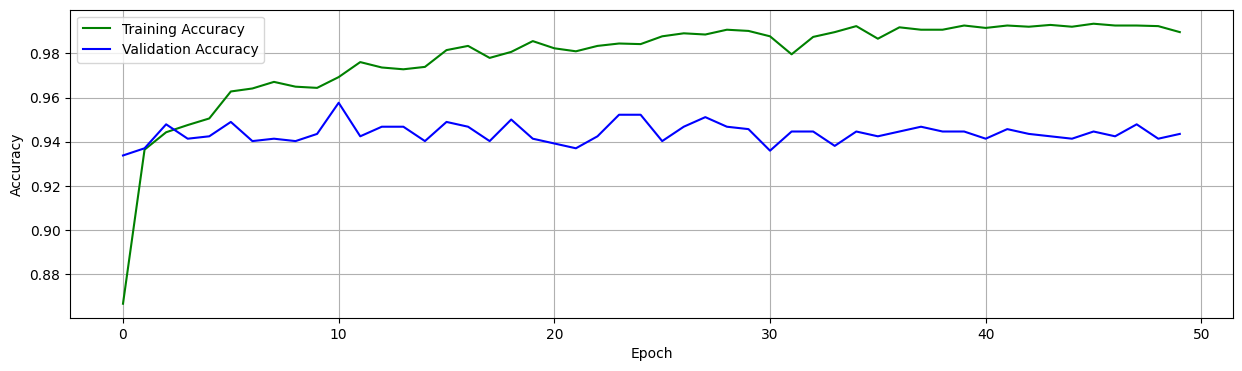

In [10]:
train_loss = training_results.history["loss"]
valid_loss = training_results.history["val_loss"]
train_acc  = training_results.history["acc"]
valid_acc  = training_results.history["val_acc"]

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

### Bayes NN model

In [11]:
train_y = train_y_
test_y = test_y_

In [12]:
train_y.shape, test_y.shape

((3680,), (921,))

In [13]:
lr=0.08

In [14]:
@zs.meta_bayesian_net(scope="bnn", reuse_variables=True)
def build_bnn(x, layer_sizes, n_particles):
    bn = zs.BayesianNet()
    h = tf.tile(x[None, ...], [n_particles, 1, 1])
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w = bn.normal("w" + str(i), tf.zeros([n_out, n_in + 1]), std=1.,
                      group_ndims=2, n_samples=n_particles)
        h = tf.concat([h, tf.ones(tf.shape(h)[:-1])[..., None]], -1)
        h = tf.einsum("imk,ijk->ijm", w, h) / tf.sqrt(
            tf.cast(tf.shape(h)[2], tf.float32))
        if i < len(layer_sizes) - 2:
            h = tf.nn.relu(h)

    y = bn.categorical('y', h)
    bn.deterministic('y_logit', h)
    return bn

In [15]:
@zs.reuse_variables(scope="variational")
def build_mean_field_variational(layer_sizes, n_particles):
    bn = zs.BayesianNet()
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w_mean = tf.get_variable(
            "w_mean_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        w_logstd = tf.get_variable(
            "w_logstd_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        bn.normal("w" + str(i), w_mean, logstd=w_logstd,
                  n_samples=n_particles, group_ndims=2)
    return bn

In [16]:
n_particles = tf.placeholder(tf.int32, shape=[], name='n_particles')
x = tf.placeholder(tf.float32, shape=(None, x_dim))
y = tf.placeholder(tf.int32, shape=(None))

w_names = ["w" + str(i) for i in range(len(layer_sizes) - 1)]

x_obs = tf.tile(tf.expand_dims(x, 0), [n_particles, 1, 1])
y_obs = tf.tile(tf.expand_dims(y, 0), [n_particles, 1])

In [17]:
model = build_bnn(x, layer_sizes, n_particles)
variational = build_mean_field_variational(layer_sizes, n_particles)

def log_joint(bn):
    log_pe = bn.cond_log_prob(w_names)
    log_py_xe = bn.cond_log_prob('y')
    return tf.add_n(log_pe) + tf.reduce_mean(log_py_xe, 1) * n_train

model.log_joint = log_joint

lower_bound = zs.variational.elbo(model, {'y': y_obs},
                                    variational=variational, axis=0)

In [18]:
y_logit = lower_bound.bn["y_logit"]
h_pred = tf.reduce_mean(tf.nn.softmax(y_logit), 0)
y_pred = tf.argmax(h_pred, 1, output_type=tf.int32)
acc = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32))

cost = tf.reduce_mean(lower_bound.sgvb()) / n_train
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
infer = optimizer.minimize(cost)

In [19]:
lower_bound = tf.reduce_mean(lower_bound) / n_train

params = tf.trainable_variables()
for i in params:
    print('variable name = {}, shape = {}'
            .format(i.name, i.get_shape()))

variable name = dense/kernel:0, shape = (57, 64)
variable name = dense/bias:0, shape = (64,)
variable name = dense_1/kernel:0, shape = (64, 32)
variable name = dense_1/bias:0, shape = (32,)
variable name = dense_2/kernel:0, shape = (32, 16)
variable name = dense_2/bias:0, shape = (16,)
variable name = dense_3/kernel:0, shape = (16, 2)
variable name = dense_3/bias:0, shape = (2,)
variable name = Adam/iterations:0, shape = ()
variable name = Adam/lr:0, shape = ()
variable name = Adam/beta_1:0, shape = ()
variable name = Adam/beta_2:0, shape = ()
variable name = Adam/decay:0, shape = ()
variable name = training/Adam/Variable:0, shape = (57, 64)
variable name = training/Adam/Variable_1:0, shape = (64,)
variable name = training/Adam/Variable_2:0, shape = (64, 32)
variable name = training/Adam/Variable_3:0, shape = (32,)
variable name = training/Adam/Variable_4:0, shape = (32, 16)
variable name = training/Adam/Variable_5:0, shape = (16,)
variable name = training/Adam/Variable_6:0, shape = (1

In [20]:
lb_samples = 10
ll_samples = 5000
epochs = 50
batch_size = 20
iters = (n_train-1) // batch_size + 1
test_batch_size = 20
test_iters = (n_test-1) // test_batch_size + 1
test_freq = 1

In [21]:
train_accs = []
test_accs= []

train_lbs = []
test_lbs = []


# Run the inference
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1, epochs + 1):
        time_epoch = -time.time()
        indices = np.random.permutation(n_train)
        train_X_standard = train_X_standard[indices]
        train_y = train_y[indices]
        lbs = []
        correct = 0
        for t in range(iters):
            x_batch = train_X_standard[t * batch_size:(t + 1) * batch_size]
            y_batch = train_y[t * batch_size:(t + 1) * batch_size]
            _, lb = sess.run(
                [infer, lower_bound],
                feed_dict={n_particles: lb_samples,
                            x: x_batch, y: y_batch})
            lbs.append(lb)
            if epoch % test_freq == 0 or epoch == 0:
                train_acc1 = sess.run(
                    [acc],
                    feed_dict={n_particles: ll_samples,
                                x: x_batch, y: y_batch})
                correct += train_acc1[0] * len(x_batch)
        if epoch % test_freq == 0 or epoch == 0:
            train_accs.append(correct / n_train)

        time_epoch += time.time()
        train_lb = np.mean(lbs)
        train_lbs.append(train_lb)
        print('Epoch {} ({:.1f}s): Lower bound = {}'.format(
            epoch, time_epoch, train_lb))

        if epoch % test_freq == 0 or epoch == 0:
            time_test = -time.time()
            test_lbs_batch = []
            correct = 0
            for t in range(test_iters):
                x_batch = test_X_standard[t * test_batch_size:(t + 1) * test_batch_size]
                y_batch = test_y[t * test_batch_size:(t + 1) * test_batch_size]
                lb, acc1 = sess.run(
                    [lower_bound, acc],
                    feed_dict={n_particles: ll_samples,
                                x: x_batch, y: y_batch})
                test_lbs_batch.append(lb)
                correct += acc1 * len(x_batch)
            time_test += time.time()
            test_acc = correct / n_test
            test_accs.append(test_acc)
            test_lbs.append(np.mean(test_lbs_batch))
            print('>>> TEST ({:.1f}s)'.format(time_test))
            print('>> Test lower bound = {}'.format(np.mean(test_lbs_batch)))
            print('>> Test accuracy = {}'.format(test_acc))


Epoch 1 (80.7s): Lower bound = -0.5956687927246094
>>> TEST (27.8s)
>> Test lower bound = -0.46121522784233093
>> Test accuracy = 0.9250814218345087
Epoch 2 (72.5s): Lower bound = -0.4655317962169647
>>> TEST (27.1s)
>> Test lower bound = -0.43192893266677856
>> Test accuracy = 0.935939186429615
Epoch 3 (72.0s): Lower bound = -0.44005775451660156
>>> TEST (26.5s)
>> Test lower bound = -0.3816644847393036
>> Test accuracy = 0.9424538446689402
Epoch 4 (72.0s): Lower bound = -0.4257902204990387
>>> TEST (28.0s)
>> Test lower bound = -0.40073341131210327
>> Test accuracy = 0.9261671997178003
Epoch 5 (71.8s): Lower bound = -0.4216255247592926
>>> TEST (26.8s)
>> Test lower bound = -0.40040645003318787
>> Test accuracy = 0.9326818566627793
Epoch 6 (72.2s): Lower bound = -0.42657333612442017
>>> TEST (27.4s)
>> Test lower bound = -0.41006985306739807
>> Test accuracy = 0.9315960813681803
Epoch 7 (71.9s): Lower bound = -0.4147830605506897
>>> TEST (27.4s)
>> Test lower bound = -0.4026985168457

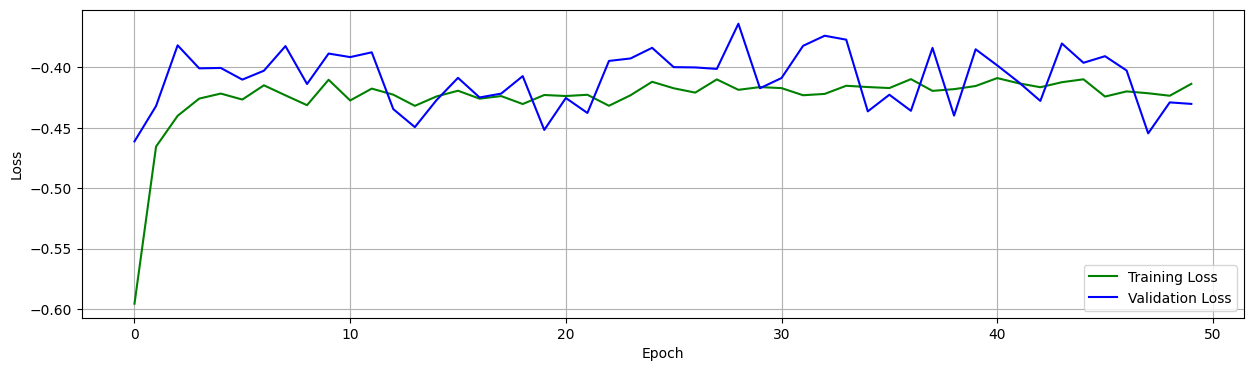

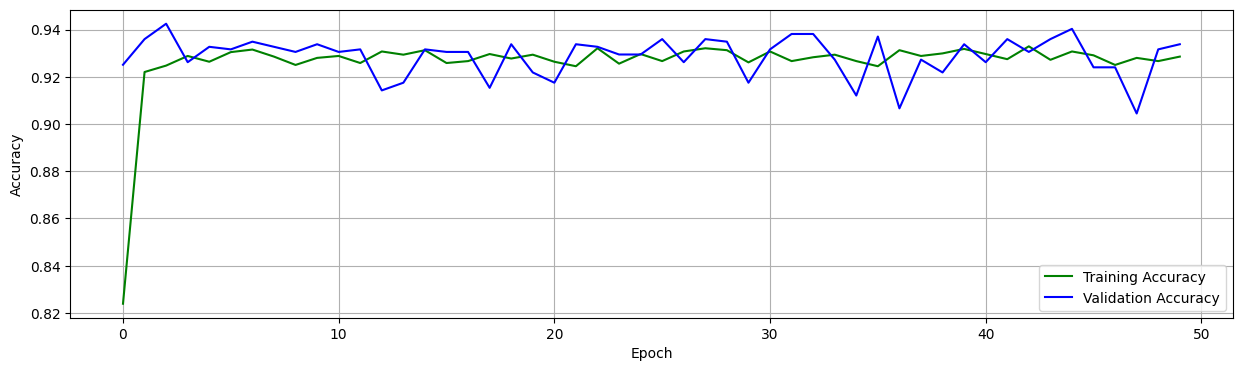

In [22]:
plot_results([ train_lbs, test_lbs ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"])

plot_results([ train_accs, test_accs ],
            ylabel="Accuracy",
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

In [23]:
test_accs[:10]

[0.9250814218345087,
 0.935939186429615,
 0.9424538446689402,
 0.9261671997178003,
 0.9326818566627793,
 0.9315960813681803,
 0.934853405957631,
 0.932681855368433,
 0.930510304779235,
 0.9337676319573782]